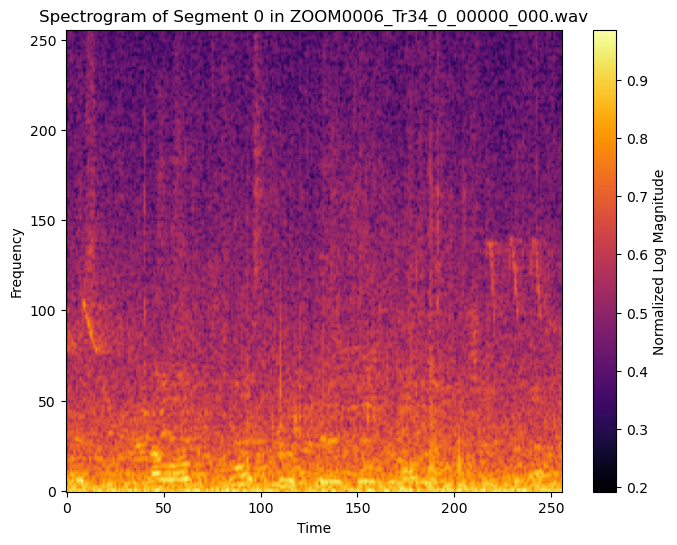

In [2]:
import os
import numpy as np
import librosa
import cv2
import cupy as cp
import matplotlib.pyplot as plt
from cupyx.scipy import signal as cupy_signal

# 📌 **配置参数**
class config:
    FS = 32000  # 采样率
    N_FFT = 1095  # FFT 点数
    WIN_SIZE = 412  # 频谱窗口大小
    WIN_LAP = 100  # 频谱窗口重叠大小
    MIN_FREQ = 40  # 最小频率
    MAX_FREQ = 15000  # 最大频率
    SEGMENT_DURATION = 3  # 每段 3 秒
    SPEC_SIZE = (256, 256)  # 频谱图大小 (宽, 高)

# 📌 **频谱转换函数**
def oog2spec_via_cupy(audio_data):
    audio_data = cp.array(audio_data)

    # 处理 NaN 数据
    mean_signal = cp.nanmean(audio_data)
    audio_data = cp.nan_to_num(audio_data, nan=mean_signal) if cp.isnan(audio_data).mean() < 1 else cp.zeros_like(audio_data)

    # 计算频谱
    frequencies, times, spec_data = cupy_signal.spectrogram(
        audio_data, 
        fs=config.FS, 
        nfft=config.N_FFT, 
        nperseg=config.WIN_SIZE, 
        noverlap=config.WIN_LAP, 
        window='hann'
    )

    # 过滤频率范围
    valid_freq = (frequencies >= config.MIN_FREQ) & (frequencies <= config.MAX_FREQ)
    spec_data = spec_data[valid_freq, :]

    # 对数变换和归一化
    spec_data = cp.log10(spec_data + 1e-20)
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()
    
    return spec_data.get()

# 📌 **查看音频指定 `seg_idx` 的声谱图**
def view_audio_segment(file_path, seg_idx):
    # 读取音频
    try:
        audio_data, _ = librosa.load(file_path, sr=config.FS)
    except Exception as e:
        print(f"❌ 加载失败: {file_path}, 错误: {e}")
        return
    
    # 计算音频总时长
    total_duration = len(audio_data) / config.FS
    num_segments = int(np.floor(total_duration / config.SEGMENT_DURATION))

    if seg_idx >= num_segments:
        print(f"❌ 错误: 该音频最多有 {num_segments} 个 segments，无法访问 {seg_idx}")
        return

    # 获取 `seg_idx` 片段
    start_idx = seg_idx * config.SEGMENT_DURATION * config.FS
    end_idx = start_idx + config.SEGMENT_DURATION * config.FS
    segment_audio = audio_data[start_idx:end_idx]

    # 生成频谱图
    spec_data = oog2spec_via_cupy(segment_audio)

    # 调整尺寸
    spec_data = cv2.resize(spec_data, config.SPEC_SIZE, interpolation=cv2.INTER_AREA)

    # 📌 **可视化声谱图**
    plt.figure(figsize=(8, 6))
    plt.imshow(spec_data, cmap='inferno', aspect='auto', origin='lower')
    plt.colorbar(label="Normalized Log Magnitude")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.title(f"Spectrogram of Segment {seg_idx} in {os.path.basename(file_path)}")
    plt.show()

# **示例运行**
audio_file = "E:/AMR/DA/Projekt/data/data_from_betreuer/Ming Lin/Ming Lin/Elisenbrunnen/12.05.2015/ZOOM0006_Tr34_0_00000_000.wav"
segment_index = 0  # 选择要查看的片段索引
view_audio_segment(audio_file, segment_index)


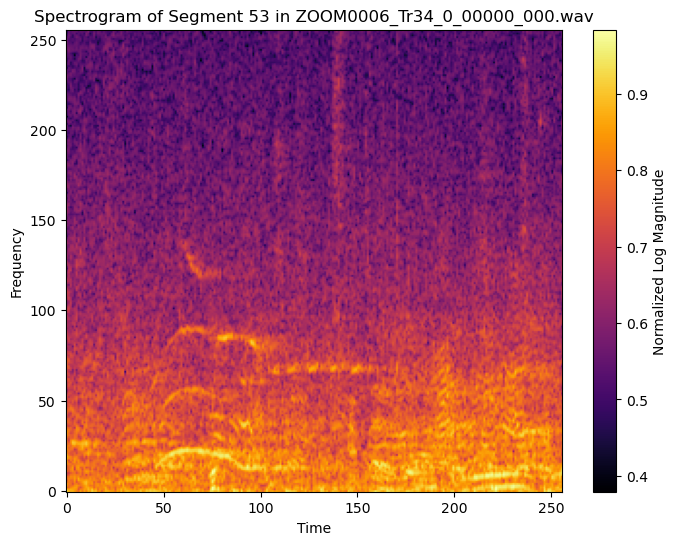

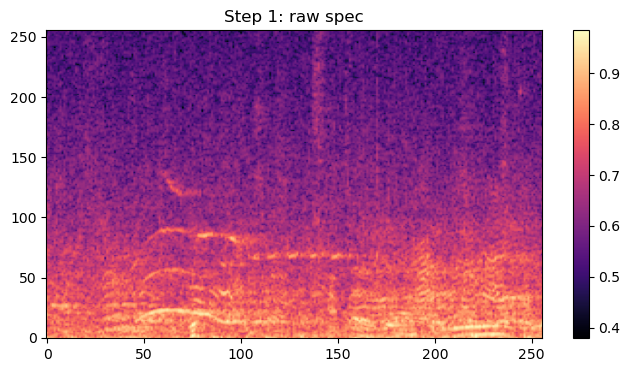

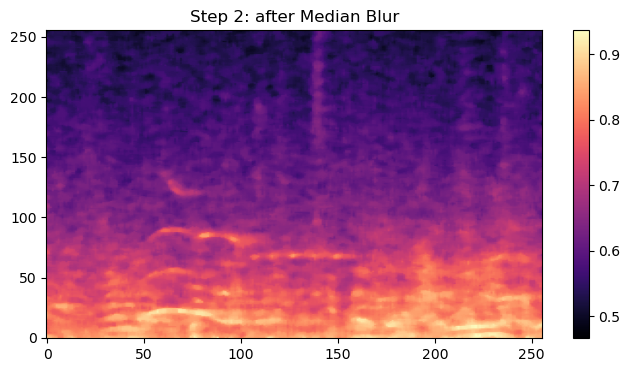

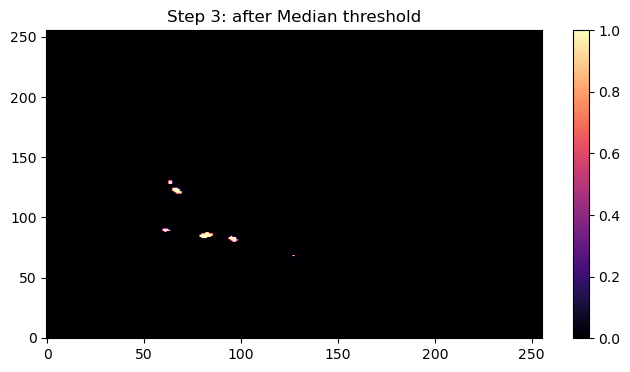

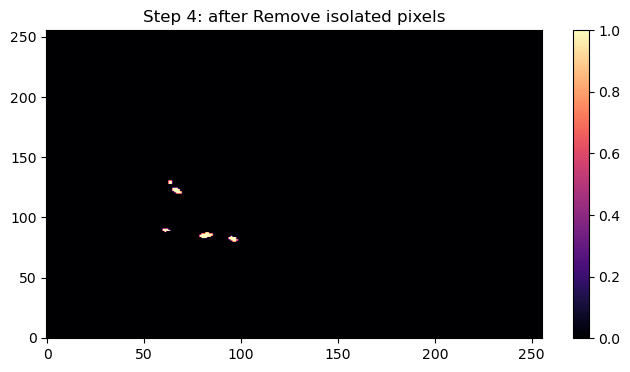

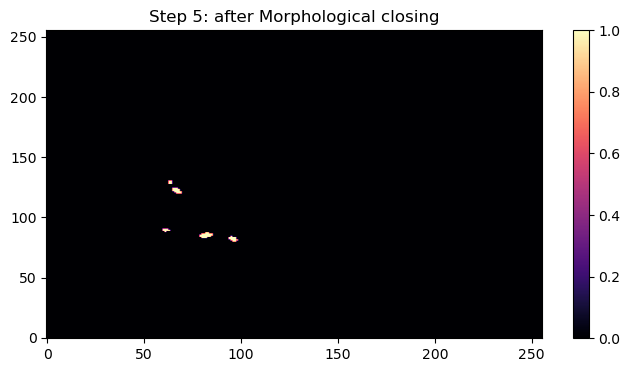

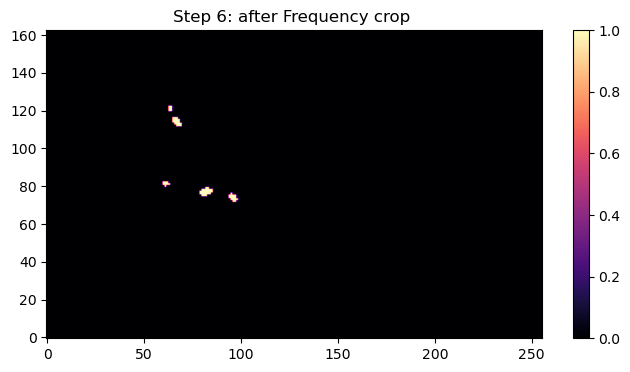

Step 7: Count active rows: 30.0
Step 8: has bird? True
🔍 该段音频 53 是否含有鸟声? ✅ 是


In [29]:
import os
import numpy as np
import librosa
import cv2
import cupy as cp
import matplotlib.pyplot as plt
from cupyx.scipy import signal as cupy_signal
from scipy import ndimage

# 📌 **配置参数**
class config:
    FS = 32000  # 采样率
    N_FFT = 1095  # FFT 点数
    WIN_SIZE = 412  # 频谱窗口大小
    WIN_LAP = 100  # 频谱窗口重叠大小
    MIN_FREQ = 600  # 最小频率
    MAX_FREQ = 15000  # 最大频率
    SEGMENT_DURATION = 3  # 每段 3 秒
    SPEC_SIZE = (256, 256)  # 频谱图大小 (宽, 高)

# 📌 **频谱转换函数**
def oog2spec_via_cupy(audio_data):
    audio_data = cp.array(audio_data)

    # 处理 NaN 数据
    mean_signal = cp.nanmean(audio_data)
    audio_data = cp.nan_to_num(audio_data, nan=mean_signal) if cp.isnan(audio_data).mean() < 1 else cp.zeros_like(audio_data)

    # 计算频谱
    frequencies, times, spec_data = cupy_signal.spectrogram(
        audio_data, 
        fs=config.FS, 
        nfft=config.N_FFT, 
        nperseg=config.WIN_SIZE, 
        noverlap=config.WIN_LAP, 
        window='hann'
    )

    # 过滤频率范围
    valid_freq = (frequencies >= config.MIN_FREQ) & (frequencies <= config.MAX_FREQ)
    spec_data = spec_data[valid_freq, :]

    # 对数变换和归一化
    spec_data = cp.log10(spec_data + 1e-20)
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()
    
    return spec_data.get()

# 📌 **可视化中间步骤**
def visualize_step(title, img):
    plt.figure(figsize=(8, 4))
    plt.imshow(img, aspect='auto', cmap='magma', origin='lower')
    plt.colorbar()
    plt.title(title)
    plt.show()

# 📌 **hasBird 检测函数**
def hasBird_debug(spec, threshold=16):
    img = spec.copy()

    # STEP 1: 原始频谱图
    visualize_step("Step 1: raw spec", img)
    
    # STEP 2: Median blur
    img = cv2.medianBlur(img, 5)
    visualize_step("Step 2: after Median Blur", img)

    # STEP 3: Median threshold
    col_median = np.median(img, axis=0, keepdims=True)
    row_median = np.median(img, axis=1, keepdims=True)
    img[img < row_median * 1.15] = 0
    img[img < col_median * 1.15] = 0  # baseline = 1.2
    img[img > 0] = 1
    visualize_step("Step 3: after Median threshold", img)

    # STEP 4: Remove isolated pixels
    struct = np.ones((3, 3))
    id_regions, num_ids = ndimage.label(img, structure=struct)
    id_sizes = np.array(ndimage.sum(img, id_regions, range(num_ids + 1)))
    area_mask = (id_sizes == 1)
    img[area_mask[id_regions]] = 0
    visualize_step("Step 4: after Remove isolated pixels", img)

    # STEP 5: Morphological closing
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5, 5), np.float32))
    visualize_step("Step 5: after Morphological closing", img)

    # STEP 6: Frequency crop (keeping middle frequency range)
    img = img[8:-85, :]
    visualize_step("Step 6: after Frequency crop ", img)

    # STEP 7: Count active rows
    row_max = np.max(img, axis=1)
    row_max = ndimage.binary_dilation(row_max, iterations=2).astype(row_max.dtype)
    rthresh = row_max.sum()

    print(f"Step 7: Count active rows: {rthresh}")

    # STEP 8: Apply threshold
    result = rthresh >= threshold
    print(f"Step 8: has bird? {result}")
    return result

# 📌 **从音频提取 `seg_idx` 片段并检测是否含鸟声**
def process_audio_segment(file_path, seg_idx, threshold=16):
    # 读取音频
    try:
        audio_data, _ = librosa.load(file_path, sr=config.FS)
    except Exception as e:
        print(f"❌ 加载失败: {file_path}, 错误: {e}")
        return
    
    # 计算音频总时长
    total_duration = len(audio_data) / config.FS
    num_segments = int(np.floor(total_duration / config.SEGMENT_DURATION))

    if seg_idx >= num_segments:
        print(f"❌ 错误: 该音频最多有 {num_segments} 个 segments，无法访问 {seg_idx}")
        return

    # 获取 `seg_idx` 片段
    start_idx = seg_idx * config.SEGMENT_DURATION * config.FS
    end_idx = start_idx + config.SEGMENT_DURATION * config.FS
    segment_audio = audio_data[start_idx:end_idx]

    # 生成频谱图
    spec_data = oog2spec_via_cupy(segment_audio)

    # 调整尺寸
    spec_data = cv2.resize(spec_data, config.SPEC_SIZE, interpolation=cv2.INTER_AREA)

    # 📌 **可视化声谱图**
    plt.figure(figsize=(8, 6))
    plt.imshow(spec_data, cmap='inferno', aspect='auto', origin='lower')
    plt.colorbar(label="Normalized Log Magnitude")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.title(f"Spectrogram of Segment {seg_idx} in {os.path.basename(file_path)}")
    plt.show()

    # 📌 **使用 hasBird 函数检测是否有鸟声**
    has_bird = hasBird_debug(spec_data, threshold)
    print(f"🔍 该段音频 {seg_idx} 是否含有鸟声? {'✅ 是' if has_bird else '❌ 否'}")

# **示例运行**
audio_file = "E:/AMR/DA/Projekt/data/data_from_betreuer/Ming Lin/Ming Lin/Elisenbrunnen/12.05.2015/ZOOM0006_Tr34_0_00000_000.wav"
#ZOOM0007_Tr34
#ZOOM0006_Tr34_0_00000_000.wav
segment_index = 53  # 选择要查看的片段索引
process_audio_segment(audio_file, segment_index)
